# Проект: Построение модели классификации комментариев для интернет-магазина

**Оглавление**<a id='toc0_'></a>    
- 1. [Загрузка и подготовка данных](#toc1_)    
  - 1.1. [Загрузка и обзор данных](#toc1_1_)    
  - 1.2. [Подготовка данных](#toc1_2_)    
  - 1.3. [Разделение данных на выборки](#toc1_3_)    
  - 1.4. [Векторизация признаков](#toc1_4_)    
  - 1.5. [Вывод по результатам раздела 1](#toc1_5_)    
- 2. [Обучение моделей](#toc2_)    
  - 2.1. [Выбор моделей](#toc2_1_)    
  - 2.2. [Классификатор Байеса с распределением Бернулли](#toc2_2_)    
  - 2.3. [Логистическая регрессия](#toc2_3_)    
  - 2.4. [Метод опорных векторов](#toc2_4_)    
  - 2.5. [Стохастический градиентный спуск](#toc2_5_)    
  - 2.6. [Градиентный бустинг](#toc2_6_)    
  - 2.7. [Вывод по результатам раздела 2](#toc2_7_)    
- 3. [Проверка на тестовой выборке](#toc3_)    
  - 3.1. [Вывод по результатам раздела 3](#toc3_1_)    
- 4. [Общий вывод](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Задание:**

Интернет-магазин «Викишоп» запускает новый сервис, в котором пользователи могут редактировать и дополнять описания товаров. Клиенты могут предлагать свои правки и комментировать изменения других. Требуется разработать инструмент, который будет находить токсичные (отрицательные) комментарии и отправлять их на модерацию. 

Предоставлен набор данных с разметкой о токсичности правок. Данные находятся в файле "toxic_comments.csv". Столбец "text" содержит текст комментария, столбец "toxic" — целевой признак.

Необходимо:
- Загрузить и обработать исходные данные.
- Построить и обучить несколько моделей классифицировать комментарии на позитивные и негативные. При этом значение метрики качества "F1" модели должно быть не меньше 0,75.
- Проверить данные на тестовой выборке и сделать выводы.

План работы:
1. Загрузка и подготовка данных.
2. Обучение моделей.
3. Проверка на тестовой выборке.
4. Общий вывод.

## 1. <a id='toc1_'></a>[Загрузка и подготовка данных](#toc0_)

In [2]:
# подключение библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time
from IPython.display import display

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# константы
RST = 12345 # значение random_state

### 1.1. <a id='toc1_1_'></a>[Загрузка и обзор данных](#toc0_)

In [3]:
# загрузка файла
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except FileNotFoundError:
    data = pd.read_csv('D:\Education\Data Science\Проекты курса DS\Проект_13\datasets\\toxic_comments.csv', index_col=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
118342,William Windsor (goat) \n\nIs this William Windsor (goat) any relation to William Windsor (Fish) ? link here,0
74703,You to. 82.132.218.163,0
79940,"Thank you for your apology. I accept it, such as it is. It is a good first step in repairing what was broken here - the trust that we are all working in an impartial environment.",0
152833,IM BACK!! AND NOW IN DC!!!! HAHA VARY,0
16524,Asian Supremacy\nYou voted to delete the article Asian supremacy because you felt it was unverifiable. It is verifiable. The organization Goldsea supports Asian supremacy.,0



Количество полных дубликатов: 0


Статистическая информация:


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


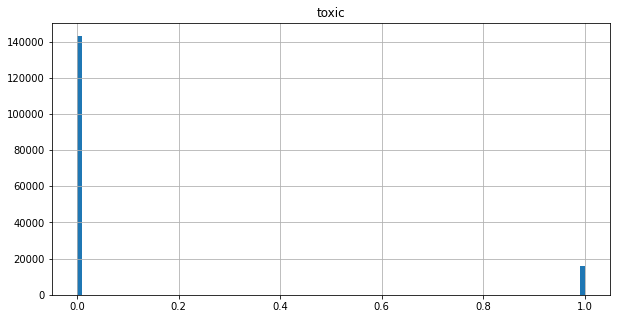

In [4]:
# обзор данных
data.info()
pd.set_option('display.max_colwidth', None)
display(pd.concat([data.head(5), data.sample(5)]))

# проверка на наличие дубликатов
print('\nКоличество полных дубликатов:', data.duplicated().sum(), end='\n\n')

# отображение статистической информации
print('\nСтатистическая информация:')
display(data.describe())
data.hist(bins=100, figsize=(10,5))
plt.show()

В загруженных данных около 160 тыс. записей. Этого достаточно для обучения моделей. Пропусков нет, дубликаты отсутствуют, аномальных значений нет, типы данных столбцов соответствуют содержанию.

Наблюдается дисбаланс классов в пользу позитивных отзывов в соотношении примерно 10:1.

### 1.2. <a id='toc1_2_'></a>[Подготовка данных](#toc0_)

В рамках подготовки данных выполним следующие действия:
- удаление лишних символов;
- лемматизация;
- удаление стоп-слов.

Используем средства библиотеки `spacy`, которые содержат требуемые функции.

In [5]:
# инициализация лемматизации
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

# функция лемматизации текста с удалением стоп-слов и символов, кроме букв
def lemmatiz(text):
    return ' '.join(token.lemma_ for token in nlp(text) if (not token.is_stop and token.is_alpha)).lower()

In [5]:
%%time
# удаление лишних символов и лемматизация с помощью пользовательской функции
data['text_lemm'] = data['text'].map(lemmatiz)

# просмотр результата
display(data.head())

,text,toxic,text_lemm
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edit username hardcore metallica fan revert vandalism closure gas vote new york dolls fac remove template talk page retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,match background colour seemingly stuck thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man try edit war guy constantly remove relevant information talk edit instead talk page care formatting actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,real suggestion improvement wonder section statistic later subsection type accident think reference need tidy exact format ie date format etc later preference format style reference want let know appear backlog article review guess delay reviewer turn list relevant form eg wikipedia
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page


CPU times: user 17min 14s, sys: 4.57 s, total: 17min 19s
Wall time: 17min 19s


### 1.3. <a id='toc1_3_'></a>[Разделение данных на выборки](#toc0_)

Разделим данные на обучающую и тестовую выборки, в тестовую выборку отложим 20% от имеющихся данных. Обучение всех моделей будем осуществлять с применением кросс-валидации, поэтому формирование отдельной валидационной выборки не требуется.

In [6]:
# разделение исходных данных на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=.2, random_state=RST, stratify=data['toxic'])
# вывод информации о выборках
print(f'''
Обучающая выборка (train): {train.shape}
    - баланс классов: {train['toxic'].mean():0.2%}
Тестовая выборка (test): {test.shape}
    - баланс классов: {test['toxic'].mean():0.2%}''')


Обучающая выборка (train): (127433, 3)
    - баланс классов: 10.16%
Тестовая выборка (test): (31859, 3)
    - баланс классов: 10.16%


Рассмотрим распределение отзывов по количеству слов в них.

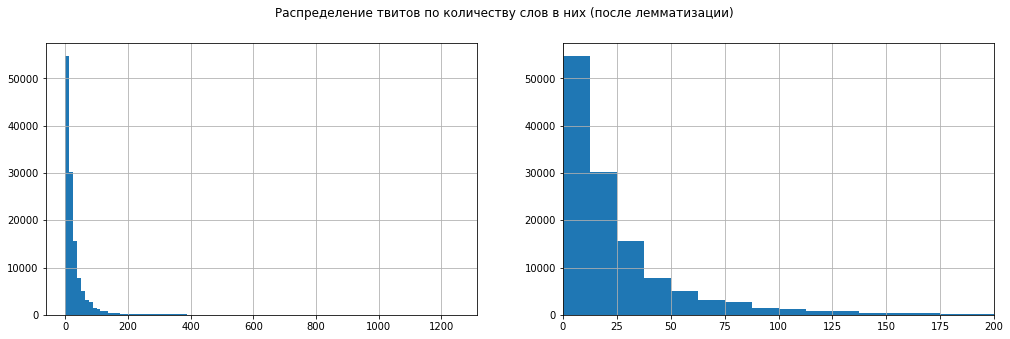

Количество сообщений c длиной больше 200 слов: 2011


In [7]:
text_len = [len(str(i).split()) for i in train['text_lemm']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
fig.suptitle('Распределение твитов по количеству слов в них (после лемматизации)')
pd.Series(text_len).hist(bins = 100, ax=ax[0])
pd.Series(text_len).hist(bins = 100, ax=ax[1])
ax[1].set_xlim(0, 200)
plt.show()

print('Количество сообщений c длиной больше 200 слов:', pd.Series(text_len).loc[lambda x: (x > 200)].count())

Для сокращения размерности матрицы признаков, отбросим длинные твиты с количеством слов больше 200.

In [8]:
train = train[train['text_lemm'].map(lambda x: len(str(x).split())) < 200]
print(f'''
Обучающая выборка (train): {train.shape}
    - баланс классов: {train['toxic'].mean():0.2%}''')


Обучающая выборка (train): (125407, 3)
    - баланс классов: 10.14%


Разделим обучающую и тестовую выборки на выборки с признаками (`features`) и выборки с целевым признаком (`target`).

In [9]:
features_train = train['text_lemm'].copy()
target_train = train['toxic'].copy()
features_test = test['text_lemm'].copy()
target_test = test['toxic'].copy()

# вывод итоговой информации о выборках
print(f'''
Обучающая выборка (features_train, target_train):
    - признаки {features_train.shape};
    - целевой признак ({target_train.shape[0]})
        - баланс классов (процент отрицательных отзывов): {target_train.mean():0.2%}.
Тестовая выборка (features_test, target_test):
    - признаки {features_test.shape};
    - целевой признак ({target_test.shape[0]})
        - баланс классов (процент отрицательных отзывов): {target_test.mean():0.2%}.
''')


Обучающая выборка (features_train, target_train):
    - признаки (125407,);
    - целевой признак (125407)
        - баланс классов (процент отрицательных отзывов): 10.14%.
Тестовая выборка (features_test, target_test):
    - признаки (31859,);
    - целевой признак (31859)
        - баланс классов (процент отрицательных отзывов): 10.16%.



### 1.4. <a id='toc1_4_'></a>[Векторизация признаков](#toc0_)

Осуществим векторизацию признаков для обучающей и тестовой выборки методом `TF-IDF`.

In [10]:
vectorizer = TfidfVectorizer()
vectorizer.fit(features_train)
features_train = vectorizer.transform(features_train)
print('Матрица признаков обучающей выборки:', features_train.shape)
features_test = vectorizer.transform(features_test)
print('Матрица признаков тестовой выборки:', features_test.shape)

Матрица признаков обучающей выборки: (125407, 116806)
Матрица признаков тестовой выборки: (31859, 116806)


### 1.5. <a id='toc1_5_'></a>[Вывод по результатам раздела 1](#toc0_)

Выполнена загрузка исходных данных (около 160 тыс. записей), в ходе обзора установлено, что:
- пропусков нет;
- дубликаты отсутствуют;
- аномальных значений нет;
- типы данных столбцов соответствуют содержанию;
- имеется дисбаланс классов в сторону позитивных отзывов в соотношении примерно 10:1.

Проведены следующие мероприятия по подготовке данных:
- удаление лишних символов и стоп-слов;
- лемматизация с использованием библиотеки `spacy`;
- векторизация методом `TF-IDF` (`TfidfVectorizer`).

Исходные данные разделены на обучающую и тестовую выборки для проведения обучения и получения предсказаний моделей.

## 2. <a id='toc2_'></a>[Обучение моделей](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Выбор моделей](#toc0_)

Целевой признак категориальный (задача бинарной классификации), будем обучать и анализировать следующие модели:
- Классификатор Байеса. За счет не сложных математических расчетов вероятностей позволяет сделать быстрые предсказания. Для классификации текстов из семейства классификаторов Байеса выберем классификатор с распределением Бернулли (`BernoulliNB`), который лучше работает с небольшими текстами, такими, как отзывы в наших исходных данных.
- Логистическая регрессия (`LogisticRegression`). Классическая модель классификации, позволяющая в большинстве случаев получить хорошее качество предсказаний.
- Метод опорных векторов. Эффективно работает на больших выборках и выборках с большим количеством параметров, при этом имеет высокую производительность, поэтому подходит для обработки текстов и для нашей относительно большой обучающей выборки в 125 тыс. записей. Из семейства моделей SVC выберем модель линейных опорных векторов (`LinearSVC`), как более быструю реализацию задачи классификации.
- Модель стохастического градиентного спуска (`SGDClassifier`). В данной модели реализовано обучение линейных классификаторов, таких как опорные вектора, логистическая регрессия и другие с помощью более быстрого стохастического градиентного спуска. Это позволяет успешно применять модель к крупномасштабным задачам машинного обучения, возникающим при классификации текста и обработке естественного языка.
- Градиентный бустинг (`LightGBM`). Это ансамбль из простых моделей типа решающее дерево в котором каждая последующая базовая модель учитывает ошибку предудущей, тем самым минимизируя ошибку ансамбля. Градиентный бустинг `LightGBM` в отличии от других моделей градиентного бустинга строит несимметричные деревья ориентируясь на бОльшую величину градиента и имеет более высокую скорость обучения, сохряняя при этом высокую точность.

Подбор гиперпараметров осуществим с помощью `GridSearchCV` и кросс-валидации.

В качестве метрики используем F1, значение которой в соответствии с заданием должно быть не менее 0,75.

Для обучения моделей, подбора гиперпараметров и измерения F1 создадим пользовательскую функцию `model_fit`.

In [11]:
# функция обучения модели
# на входе: созданная модель, выборки с признаками и целевым признаком,
# гиперпараметры для подбора, количество итераций кроссвалидации
# на выходе: обученная модель, её лучший F1 и параметры
def model_fit(model_type, features, target, param_grid, cv):
    # засекаем время
    start_time = time.time()
    # подбор гиперпараметров с использованием кросс-валидации
    model = GridSearchCV(model_type, param_grid=param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
    model.fit(features, target)
    f1 = model.best_score_
    param = model.best_params_
    # подсчет времени выполнения
    time_fit = time.time() - start_time
    # вывод результатов
    print(f'''
Лучшие гиперпараметры:{pd.DataFrame.from_dict(param, orient='index').rename(columns={0:''})}
Значение F1: {f1:0.3f}
Время обучения: {time_fit:0.1f} сек. ({time.strftime("%H:%M:%S", time.gmtime(time_fit))})''')
    return model, f1, param, time_fit

### 2.2. <a id='toc2_2_'></a>[Классификатор Байеса с распределением Бернулли](#toc0_)

Для данной модели будем осуществлять подбор значений гиперпараметра адаптивного сглаживания (`alpha`).

Используем подготовленную пользовательскую функцию `model_fit`, обучим модель с применением кроссвалидации и измерим метрику F1.

In [12]:
print('Модель "классификатор Байеса с распределением Бернулли"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'alpha': [.1, .5, 1, 2, 4],
    }]

bnb_mod, bnb_f1, bnb_param, bnb_time_fit = model_fit(BernoulliNB(), features_train, target_train, param_grid, 5)

Модель "классификатор Байеса с распределением Бернулли"
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ............................................alpha=1; total time= 

Обучение модели прошло очень быстро, но качество низкое, значение метрики F1 ниже требуемого порога 0,75.

### 2.3. <a id='toc2_3_'></a>[Логистическая регрессия](#toc0_)

При обучении модели логистической регрессии осуществим подбор двух гиперпараметров: тип алгоритма `solver` и максимальное количество итераций `max_iter`.

In [13]:
print('Модель "логистическая регрессия"')
# гиперпараметры для подбора
param_grid = [{
    'solver': ['liblinear', 'sag'],
    'max_iter': [100, 200, 400]
    }]

lr_mod, lr_f1, lr_param, lr_time_fit = model_fit(LogisticRegression(random_state=RST, class_weight='balanced'),
                                                 features_train, target_train, param_grid, 5)

Модель "логистическая регрессия"
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................max_iter=100, solver=liblinear; total time=  13.9s
[CV] END .....................max_iter=100, solver=liblinear; total time=  12.7s
[CV] END .....................max_iter=100, solver=liblinear; total time=  12.3s
[CV] END .....................max_iter=100, solver=liblinear; total time=  14.0s
[CV] END .....................max_iter=100, solver=liblinear; total time=  13.9s
[CV] END ...........................max_iter=100, solver=sag; total time=   3.3s
[CV] END ...........................max_iter=100, solver=sag; total time=   3.4s
[CV] END ...........................max_iter=100, solver=sag; total time=   2.9s
[CV] END ...........................max_iter=100, solver=sag; total time=   2.9s
[CV] END ...........................max_iter=100, solver=sag; total time=   3.1s
[CV] END .....................max_iter=200, solver=liblinear; total time=  14.3s
[CV] END .......

Скорость обучения приемлемая. Качество предсказаний практически достигло требуемого значения F1.

Посмотрим влияние подбираемых гиперпараметров на качество предсказания модели.

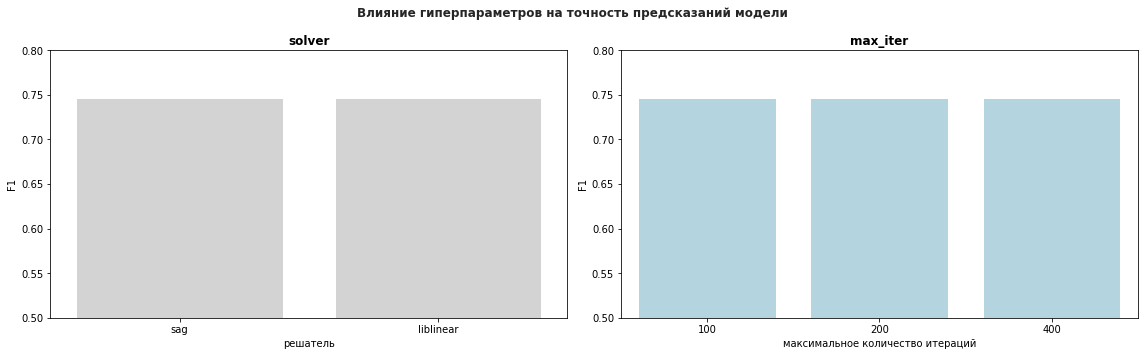

In [14]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_lr = pd.DataFrame(lr_mod.cv_results_).sort_values(by='rank_test_score')
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели', fontweight='bold')
sns.barplot(x='param_solver', y='mean_test_score', data=res_lr, ax=axes[0], color='lightgrey')
axes[0].set (xlabel='решатель', ylabel='F1')
axes[0].set_title(label = 'solver', fontweight='bold')
axes[0].set_ylim([.5, .8])
sns.barplot(x='param_max_iter', y='mean_test_score', data=res_lr, ax=axes[1], color='lightblue')
axes[1].set (xlabel='максимальное количество итераций', ylabel='F1')
axes[1].set_title(label = 'max_iter', fontweight='bold')
axes[1].set_ylim([.5, .8])
fig.tight_layout()
plt.show()

Видим, что изменение гиперпараметров не оказывает существенного влияния на значение метрики F1.

### 2.4. <a id='toc2_4_'></a>[Метод опорных векторов](#toc0_)

Осуществим подбор гиперпараметров, оказывающих основное влияние на результат модели: параметр регуляризации `C`, максимальное количество итераций `max_iter`, допуск критерия остановки `tol`.

In [15]:
print('Модель "метод опорных векторов"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'C': [.5, 1, 2, 4, 8],
    'tol': [1e-4, 1, 2, 4, 8],
    'max_iter': [500, 1000, 2000, 4000]
    }]

svc_mod, svc_f1, svc_param, svc_time_fit = model_fit(LinearSVC(random_state=RST), features_train, target_train, param_grid, 5)

Модель "метод опорных векторов"
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ....................C=0.5, max_iter=500, tol=0.0001; total time=   0.6s
[CV] END ....................C=0.5, max_iter=500, tol=0.0001; total time=   0.5s
[CV] END ....................C=0.5, max_iter=500, tol=0.0001; total time=   0.5s
[CV] END ....................C=0.5, max_iter=500, tol=0.0001; total time=   0.5s
[CV] END ....................C=0.5, max_iter=500, tol=0.0001; total time=   0.5s
[CV] END .........................C=0.5, max_iter=500, tol=1; total time=   0.3s
[CV] END .........................C=0.5, max_iter=500, tol=1; total time=   0.3s
[CV] END .........................C=0.5, max_iter=500, tol=1; total time=   0.3s
[CV] END .........................C=0.5, max_iter=500, tol=1; total time=   0.3s
[CV] END .........................C=0.5, max_iter=500, tol=1; total time=   0.3s
[CV] END .........................C=0.5, max_iter=500, tol=2; total time=   0.2s
[CV] END .....

Скорость обучения хорошая, норматив значения F1 достигнут.

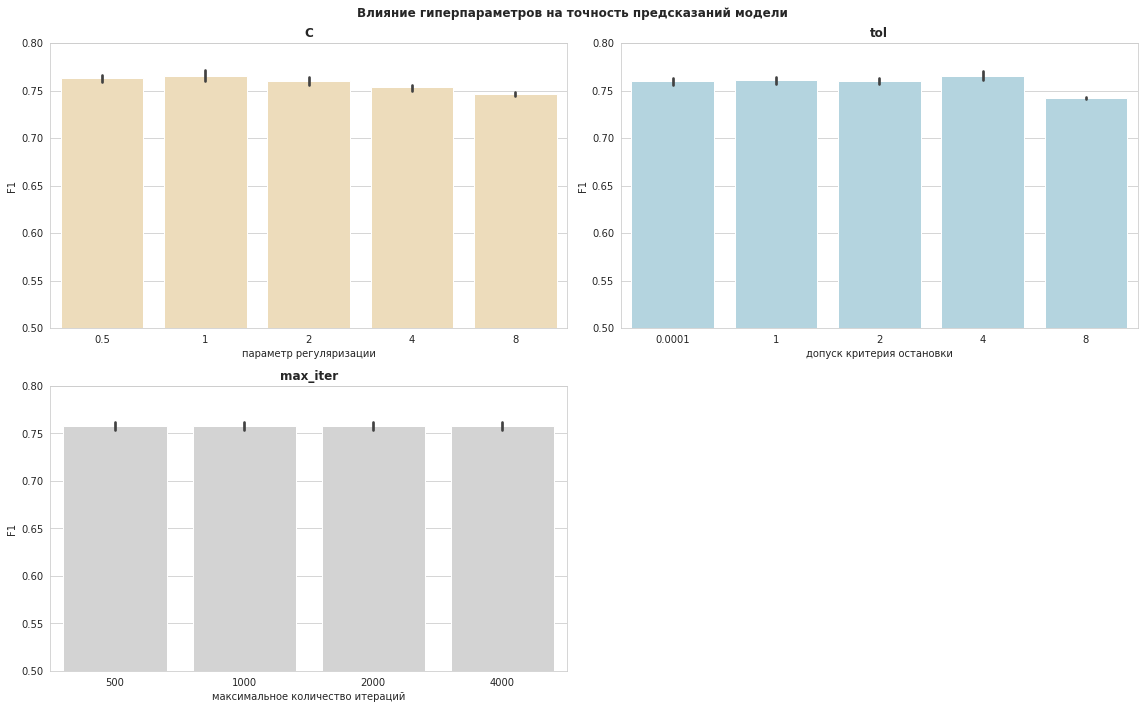

In [16]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_svc = pd.DataFrame(svc_mod.cv_results_).sort_values(by='rank_test_score')
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели', fontweight='bold')
sns.barplot(x='param_C', y='mean_test_score', data=res_svc, ax=axes[0,0], color='wheat')
axes[0,0].set (xlabel='параметр регуляризации', ylabel='F1')
axes[0,0].set_title(label = 'C', fontweight='bold')
axes[0,0].set_ylim([.5, .8])
sns.barplot(x='param_tol', y='mean_test_score', data=res_svc, ax=axes[0,1], color='lightblue')
axes[0,1].set (xlabel='допуск критерия остановки', ylabel='F1')
axes[0,1].set_title(label = 'tol', fontweight='bold')
axes[0,1].set_ylim([.5, .8])
sns.barplot(x='param_max_iter', y='mean_test_score', data=res_svc, ax=axes[1,0], color='lightgrey')
axes[1,0].set (xlabel='максимальное количество итераций', ylabel='F1')
axes[1,0].set_title(label = 'max_iter', fontweight='bold')
axes[1,0].set_ylim([.5, .8])
fig.delaxes(axes[1,1])
fig.tight_layout()
plt.show()

Параметр регуляризации (`C`) - при увеличении значения до 1 улучшает качество предсказания модели, при дальнейшем увеличении значения, качество предсказаний модели ухудшается.

Максимальное количество итераций (`max_iter`) - практически не оказывает влияния на качество модели.

Влияние изменения значений гиперпараметра допуск критерия остановки (`tol`) на метрику F1 нелинейное, лучшее значение метрики F1 достигается при значении гиперпараметра равном 4.

### 2.5. <a id='toc2_5_'></a>[Стохастический градиентный спуск](#toc0_)

Осуществим подбор гиперпараметров, оказывающих основное влияние на результат модели: функция потерь `loss`, вид регуляризации `penalty`, коэффициент регуляризации (`alpha`).

In [17]:
print('Модель "стохастический градиентный спуск"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'loss': ['hinge', 'modified_huber', 'perceptron', 'log'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3]
    }]

sgdc_mod, sgdc_f1, sgdc_param, sgdc_time_fit = model_fit(SGDClassifier(random_state=RST, max_iter=1000), 
                                                     features_train, target_train, param_grid, 5)

Модель "стохастический градиентный спуск"
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ................alpha=1e-06, loss=hinge, penalty=l2; total time=   0.6s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l2; total time=   0.6s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l2; total time=   0.5s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l2; total time=   0.6s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l2; total time=   0.6s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l1; total time=   0.9s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l1; total time=   1.0s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l1; total time=   0.9s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l1; total time=   0.9s
[CV] END ................alpha=1e-06, loss=hinge, penalty=l1; total time=   1.0s
[CV] END ........alpha=1e-06, loss=hinge, penalty=elasticnet; total time=   1.0s
[CV] 

Скорость обучения хорошая, норматив значения F1 достигнут.

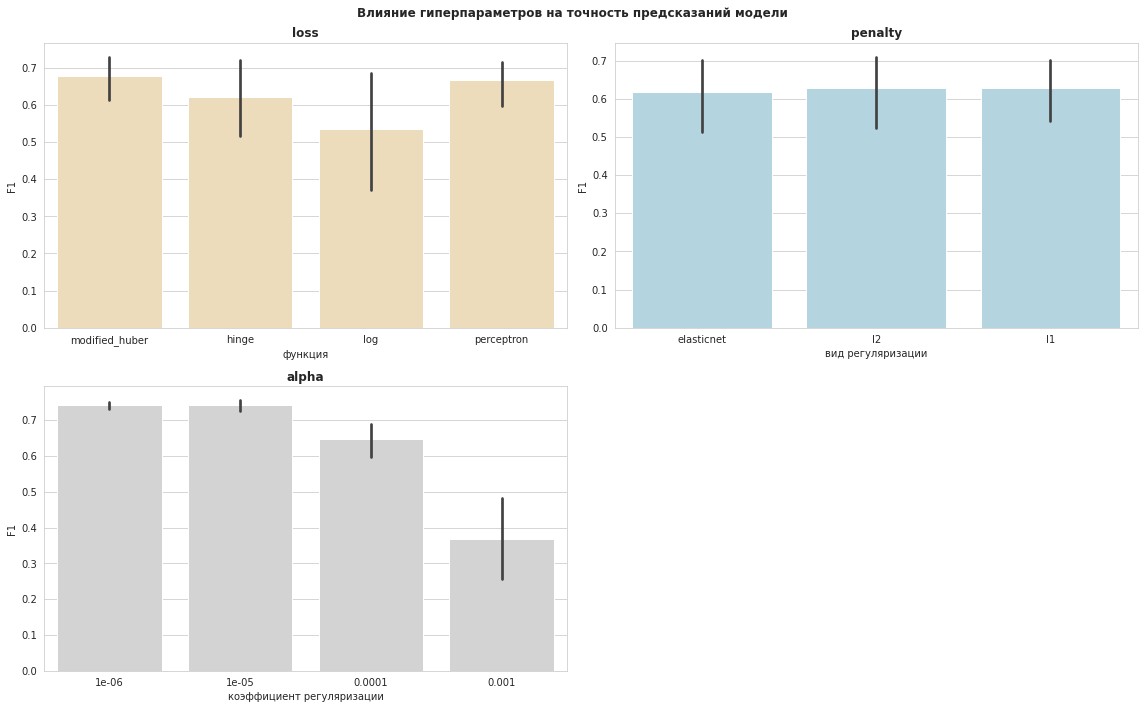

In [18]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_sgdc = pd.DataFrame(sgdc_mod.cv_results_).sort_values(by='rank_test_score')
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели', fontweight='bold')
sns.barplot(x='param_loss', y='mean_test_score', data=res_sgdc, ax=axes[0,0], color='wheat')
axes[0,0].set (xlabel='функция', ylabel='F1')
axes[0,0].set_title(label = 'loss', fontweight='bold')
#axes[0,0].set_ylim([.5, .8])
sns.barplot(x='param_penalty', y='mean_test_score', data=res_sgdc, ax=axes[0,1], color='lightblue')
axes[0,1].set (xlabel='вид регуляризации', ylabel='F1')
axes[0,1].set_title(label = 'penalty', fontweight='bold')
#axes[0,1].set_ylim([.5, .8])
sns.barplot(x='param_alpha', y='mean_test_score', data=res_sgdc, ax=axes[1,0], color='lightgrey')
axes[1,0].set (xlabel='коэффициент регуляризации', ylabel='F1')
axes[1,0].set_title(label = 'alpha', fontweight='bold')
#axes[1,0].set_ylim([.5, .8])
fig.delaxes(axes[1,1])
fig.tight_layout()
plt.show()

Влияние гиперпараметров функция потерь `loss` и коэффициент регуляризации (`alpha`) существенно и прослеживается на графиках. Влияние изменения значений гиперпараметра вид регуляризации `penalty` несущественное.

### 2.6. <a id='toc2_6_'></a>[Градиентный бустинг](#toc0_)

Осуществим подбор гиперпараметров, оказывающих основное влияние на результат модели: скорость обучения (`learning_rate`), максимальная глубина дерева (`max_depth`), количество деревьев (`n_estimators`).

In [19]:
print('Модель "градиентный бустинг"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'learning_rate': [.1, .3, .5],
    'max_depth': [3, 7, 10],
    'n_estimators': [100, 200, 400]
    }]

lgbmr_mod, lgbmr_f1, lgbmr_param, lgbmr_time_fit = model_fit(LGBMClassifier(random_state=RST, num_threads=1, n_jobs=None), 
                                                               features_train, target_train, param_grid, 5)

Модель "градиентный бустинг"
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  38.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  34.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  37.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  36.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  36.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  41.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  41.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  39.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  41.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  40.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=400; total time=  48.6s
[CV] END ...learni

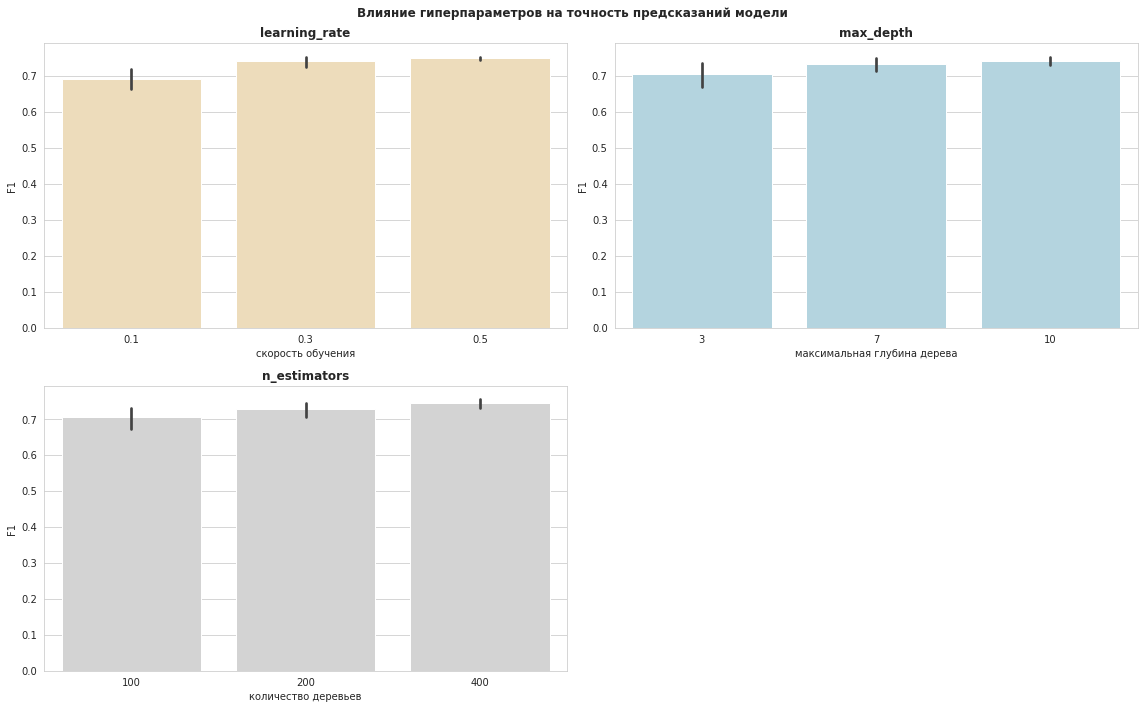

In [20]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_lgbmr = pd.DataFrame(lgbmr_mod.cv_results_).sort_values(by='rank_test_score')
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели', fontweight='bold')
sns.barplot(x='param_learning_rate', y='mean_test_score', data=res_lgbmr, ax=axes[0,0], color='wheat')
axes[0,0].set (xlabel='скорость обучения', ylabel='F1')
axes[0,0].set_title(label = 'learning_rate', fontweight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=res_lgbmr, ax=axes[0,1], color='lightblue')
axes[0,1].set (xlabel='максимальная глубина дерева', ylabel='F1')
axes[0,1].set_title(label = 'max_depth', fontweight='bold')
sns.barplot(x='param_n_estimators', y='mean_test_score', data=res_lgbmr, ax=axes[1,0], color='lightgrey')
axes[1,0].set (xlabel='количество деревьев', ylabel='F1')
axes[1,0].set_title(label = 'n_estimators', fontweight='bold')
fig.delaxes(axes[1,1])
fig.tight_layout()
plt.show()

Скорость обучения (`learning_rate`). Увеличение значения гиперпараметра улучшает качество предсказаний модели и достигает максимума при значении 0,3.

Максимальная глубина дерева (`max_depth`). Увеличение значения гиперпараметра приводит к улучшению качества предсказания модели. При достижении значений 7 - 10 достигает насыщения, после чего дальнейшее увеличение значения гиперпараметра нецелесообразно.

Количество деревьев (`n_estimators`). Увеличение значения гиперпараметра приводит к улучшению качества предсказания модели. При достижении значений 300 - 400 достигает насыщения, после чего дальнейшее увеличение значения гиперпараметра нецелесообразно.

### 2.7. <a id='toc2_7_'></a>[Вывод по результатам раздела 2](#toc0_)

Рассмотрев все модели можно сделать следующие выводы:
- Модель классификатор Байеса - самая быстрая и самая неточная.
- Модель логистическая регрессия имеет приемлемую скорость обучения и пограничное качество по значению метрики F1.
- Модели опорных векторов и стохастического градиентного спуска имеют хорошую скорость обучения и по качеству соответствуют требованию F1 > 0,75.
- Модель градиентного бустинга обеспечивает выполнение норматива по качеству предсказаний F1 > 0,75, но скорость обучения очень низная, несоразмерная качеству получаемой модели.

## 3. <a id='toc3_'></a>[Проверка на тестовой выборке](#toc0_)

Соберем результаты моделей в одну таблицу для сравнения и выбора лучшей.

In [21]:
models = pd.DataFrame(data=[
    [bnb_time_fit, bnb_mod.refit_time_, bnb_f1],
    [lr_time_fit, lr_mod.refit_time_, lr_f1],
    [svc_time_fit, svc_mod.refit_time_, svc_f1],
    [sgdc_time_fit, sgdc_mod.refit_time_, sgdc_f1],
    [lgbmr_time_fit, lgbmr_mod.refit_time_, lgbmr_f1]],
                      index=['классификатор Байеса с распределением Бернулли (BernoulliNB)',
                             'логистическая регрессия (LogisticRegression)',
                             'метод опорных векторов (LinearSVC)',
                             'стохастический градиентный спуск (SGDClassifier)',
                             'градиентный бустинг (LGBMRegressor)'],
                      columns=['общее время обучения, сек.', 'время обучения на лучших гиперпараметрах, сек', 
                               'качество предсказания (F1)']).round(
    {'общее время обучения, сек.': 1, 'время обучения на лучших гиперпараметрах, сек': 2, 'качество предсказания (F1)': 3})
display(models)

,"общее время обучения, сек.","время обучения на лучших гиперпараметрах, сек",качество предсказания (F1)
классификатор Байеса с распределением Бернулли (BernoulliNB),1.8,0.05,0.655
логистическая регрессия (LogisticRegression),250.2,4.28,0.746
метод опорных векторов (LinearSVC),269.2,0.30,0.780
стохастический градиентный спуск (SGDClassifier),141.0,0.80,0.771
градиентный бустинг (LGBMRegressor),7154.7,100.83,0.761


Сопоставляя и анализируя модели, видим следующие закономерности:
- в части качества предсказаний:
    - Классификатор Байеса дает значительно более низкое качество предсказаний.
    - Остальные модели имеют похожее качество предсказаний по метрике F1. Из них три модели: метод опорных векторов, стохастический градиентный спуск и градиентный бустинг обеспечивают выполнение требования по качеству F1 > 0,75.
    - Модель логистической регрессии немного не дотягивает до требуемого норматива качества.
- в части времени обучения:
    - Классификатор Байеса отрабатывает очень быстро, с существенным отрывом от остальных моделей. Это обусловлено самой простой математической частью и минимальным подбором гиперпараметров.
    - Модель опорных векторов также обучается с высокой скоростью.
    - Модель стохастического градиентного спуска обучается медленнее предыдущих, но достаточно быстро.
    - Модель логистической регрессии медленнее на порядок.
    - Модель градиентного бустинга медленнее на два порядка.

Лучшей по качеству предсказаний является модель опорных векторов `LinearSVC`. Модель стохастического градиентного спуска аналогична по качеству и сопоставима по времени обучения, поэтому является хорошей альтернативой. 

Проверим модель опорных векторов `LinearSVC` на тестовой выборке.

In [22]:
print(f'Значение F1 на тестовой выборке: {f1_score(target_test, svc_mod.predict(features_test)):0.3f}')

Значение F1 на тестовой выборке: 0.775


Качество предсказаний модели на тестовой выборке сопоставимо с качеством на обучающей и соответствует требованию F1 > 0,75.

### 3.1. <a id='toc3_1_'></a>[Вывод по результатам раздела 3](#toc0_)

Рассмотрено пять моделей разных типов:
- классификатор Байеса с распределением Бернулли;
- логистическая регрессия;
- метод опорных векторов;
- стохастический градиентный спуск;
- градиентный бустинг.

Все модели обучались на одинаково подготовленной выборке, для всех был осуществлен подбор наиболее влияющих на качество предсказаний гиперпараметров. В процессе работы для каждой модели проведены расчет метрики F1 и измерение времени на этапе обучения.

По совокупности факторов наиболее соответствующей требованиям Заказчика является модель опорных векторов. Данная модель была проверена на тестовой выборке, где показала хорошее качество предсказаний, соответствующее требованию F1 > 0,75.

## 4. <a id='toc4_'></a>[Общий вывод](#toc0_)

В ходе реализации проекта были получены и успешно загружены исходные данные, их количество достаточно для построения моделей. Первичный анализ показал, что пропусков в данных нет, дубликаты отсутствуют, аномальных значений нет, типы данных столбцов соответствуют содержанию. Имеется дисбаланс классов в пользу позитивных отзывов в соотношении примерно 10:1.

Проведена предобработка и подготовка данных в следующем составе:
- удаление лишних символов и стоп-слов;
- лемматизация;
- векторизация методом `TF-IDF`;
- разделение исходных данных на обучающую и тестовую выборки.

Для обучения выбрано пять моделей разных типов: классификатор Байеса, логистическая регрессия, метод опорных векторов, стохастический градиентный спуск и градиентный бустинг. Использована типовая схема обучения, реализованная в виде пользовательской функции. Подбор гиперпараметров выполнен на базе `GridSearchCV` с кросс-валидацией и расчетом метрики F1.

По результатам анализа и тестирования моделей можно сделать следующие выводы:
- Качество предсказаний по метрике F1 всех моделей, кроме классификатора Байеса сопоставимо и находится в пределах требуемого норматива. Качество классификатора Байеса существенно хуже и не укладывается в норматив F1 > 0,75.
- Обучение модели классификатора Байеса происходит очень быстро, но с худшим качеством. Обучение модели градиентный бустинг осуществляется очень медленно. Время обучения остальных моделей находится в разумных пределах.
- Наиболее подходящие требованиям модели: опорных векторов и стохастического градиентного бустинга.
- Лучшая модель - модель опорных векторов.

В качестве результата исследования, для реализации проекта Заказчика рекомендуется использовать модель опорных векторов, как наиболее соответствующую поставленным требованиям. На тестовой выборке модель показала хорошее качество предсказаний, сопоставимое с предсказаниями на обучающей выборке и соответствующее требованию F1 > 0,75.